In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.metric.metric import Metric
from financial_common.risk.risk_type import RiskType
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
import numpy as np

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
ori = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("cryptocurrencies")
market.disconnect()

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("crypto",{"ticker":"BTC-USD"})
benchmark = p.utc_date(benchmark)
benchmark["close"] = benchmark["close"].astype(float)
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"close")

In [7]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("crypto", {"ticker": ticker})
        for col in price.columns:
            if col not in ["date", "ticker"]:
                try:
                    price[col] = price[col].astype(float)
                    price.rename(columns={col:"adj"+col},inplace=True)
                except Exception as e:
                    print(str(e))
                    continue
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
        
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Metric:
                price = member.calculate(price,timeframe=30)
            for member in Indicator:
                price = member.calculate(price,timeframe=30)
            for member in RiskType:
                price = member.apply(price)
            prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 65.27it/s]


In [8]:
model_end = 2023
backtest_end = 2026
simulation = pd.concat(prices)
## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)
simulation.columns

Index(['adjstart', 'adjlow', 'adjhigh', 'adjopen', 'adjclose', 'adjvolume',
       'ticker', 'date', 'year', 'month', 'quarter', 'week', 'reference_price',
       'reference_volume', 'reference_high', 'reference_low', 'average_return',
       'standard_dev', 'rolling_dollar_volume', 'simple_moving_average',
       'drawdown', 'distance', 'optimal', 'adr', 'sma', 'sma_corr', 'ema',
       'ema_corr', 'ema_volume_corr', 'bollinger_upper', 'bollinger_lower',
       'momentum', 'roc', 'williams_r', 'obv', 'vwap', 'market_impact', 'atr',
       'coefficient_of_variation'],
      dtype='object')

In [9]:
portfolios = PortfolioSelection.generate_possible_portfolios(group_percentages=[1])

In [10]:
additional_portfolios = []

for portfolio in portfolios:
    if portfolio.timeframe.value == "week":
        for member in Indicator:
            portfolio_copy = copy.deepcopy(portfolio)
            portfolio_copy.ranking_metric = member.label
            additional_portfolios.append(portfolio_copy)


In [26]:
analysises = []
filtered_simulation = simulation[simulation["adjclose"]<=10]
for portfolio in tqdm(additional_portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = KPI.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [00:23<00:00, 32.68it/s]


In [27]:
a = pd.DataFrame(analysises)
a.columns

Index(['ranking_metric', 'timeframe', 'position_type', 'grouping_type',
       'selection_type', 'allocation_type', 'risk_type',
       'selection_percentage', 'date', 'pnl', 'downside',
       'coefficient_of_variation', 'portfolio_std', 'average_gain',
       'average_loss', 'win_loss_ratio', 'weekly_return', 'sharpe_ratio',
       'portfolio'],
      dtype='object')

In [28]:
a.groupby("pnl").first().reset_index().drop("date",axis=1).sort_values("pnl",ascending=False).head(20)

,pnl,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,downside,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio
767,13.920706,optimal,WEEK,long,DRAWDOWN,bottom,equal,coefficient_of_variation,1,0.846729,3.993004,3.486273,1.144241,0.930229,0.615955,1.062051,3.560346,<financial_common.portfolio_management.portfol...
766,13.436992,optimal,WEEK,long,AVERAGE_RETURN,bottom,equal,coefficient_of_variation,1,0.847692,3.746916,3.586148,1.149847,0.929746,0.599258,1.061643,3.326307,<financial_common.portfolio_management.portfol...
765,13.316621,optimal,WEEK,long,ROLLING_DOLLAR_VOLUME,bottom,equal,coefficient_of_variation,1,0.841294,3.814831,3.490750,1.139250,0.935035,0.615955,1.060822,3.382728,<financial_common.portfolio_management.portfol...
764,12.793622,optimal,WEEK,long,DISTANCE,bottom,equal,coefficient_of_variation,1,0.853264,3.882166,3.295486,1.139884,0.930268,0.619666,1.060160,3.424459,<financial_common.portfolio_management.portfol...
763,12.551932,optimal,WEEK,long,STANDARD_DEV,bottom,equal,coefficient_of_variation,1,0.856954,3.890728,3.226114,1.134179,0.930994,0.630798,1.059163,3.423179,<financial_common.portfolio_management.portfol...
762,12.232378,optimal,WEEK,long,SIMPLE_MOVING_AVERAGE,bottom,equal,coefficient_of_variation,1,0.842302,3.728922,3.280406,1.140187,0.931999,0.610390,1.059075,3.269111,<financial_common.portfolio_management.portfol...
761,11.531440,optimal,WEEK,short,DRAWDOWN,long_short,equal,coefficient_of_variation,1,1.001739,3.873094,2.977320,1.116156,0.926062,0.659555,1.051440,3.366475,<financial_common.portfolio_management.portfol...
760,11.207714,optimal,WEEK,short,ROLLING_DOLLAR_VOLUME,long_short,equal,coefficient_of_variation,1,0.999036,3.805948,2.944789,1.113341,0.929693,0.659555,1.050819,3.293733,<financial_common.portfolio_management.portfol...
759,10.931832,optimal,WEEK,short,STANDARD_DEV,long_short,equal,coefficient_of_variation,1,1.006820,3.798097,2.878239,1.111892,0.927777,0.665121,1.050235,3.274039,<financial_common.portfolio_management.portfol...
758,10.913527,optimal,WEEK,short,AVERAGE_RETURN,long_short,equal,coefficient_of_variation,1,1.013998,3.755114,2.906310,1.117287,0.922998,0.654917,1.050241,3.236117,<financial_common.portfolio_management.portfol...


In [29]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

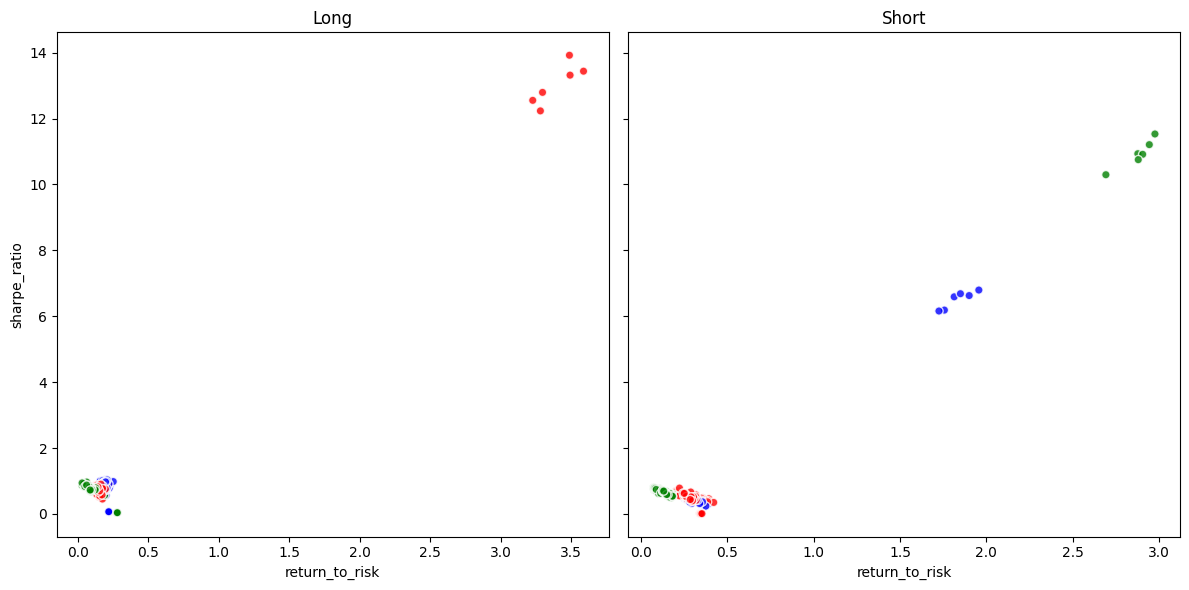

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [31]:
top = a[(a["timeframe"]=="WEEK") & (a["ranking_metric"]!="optimal")].sort_values("pnl",ascending=False).to_dict("records")[0]
top

{'ranking_metric': 'vwap',
 'timeframe': 'WEEK',
 'position_type': 'long',
 'grouping_type': 'STANDARD_DEV',
 'selection_type': 'top',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 1,
 'date': Timestamp('2025-05-15 00:00:00+0000', tz='UTC'),
 'pnl': 1.0437328299924875,
 'downside': 0.8032299354554756,
 'coefficient_of_variation': 5.227772372612797,
 'portfolio_std': 0.1996515447880602,
 'average_gain': 1.0858593337306441,
 'average_loss': 0.9240016691757232,
 'win_loss_ratio': 0.49907235621521334,
 'weekly_return': 1.0047803551966392,
 'sharpe_ratio': -2.3272164691835244,
 'portfolio': <financial_common.portfolio_management.portfolio.Portfolio at 0x1cfa1a85990>,
 'color': 'blue',
 'return_to_risk': 5.227772372612797}

In [32]:
pm = top["portfolio"]
trades = pm.trades(filtered_simulation.copy()).merge(index[["ticker","industry"]],on="ticker",how="left")
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

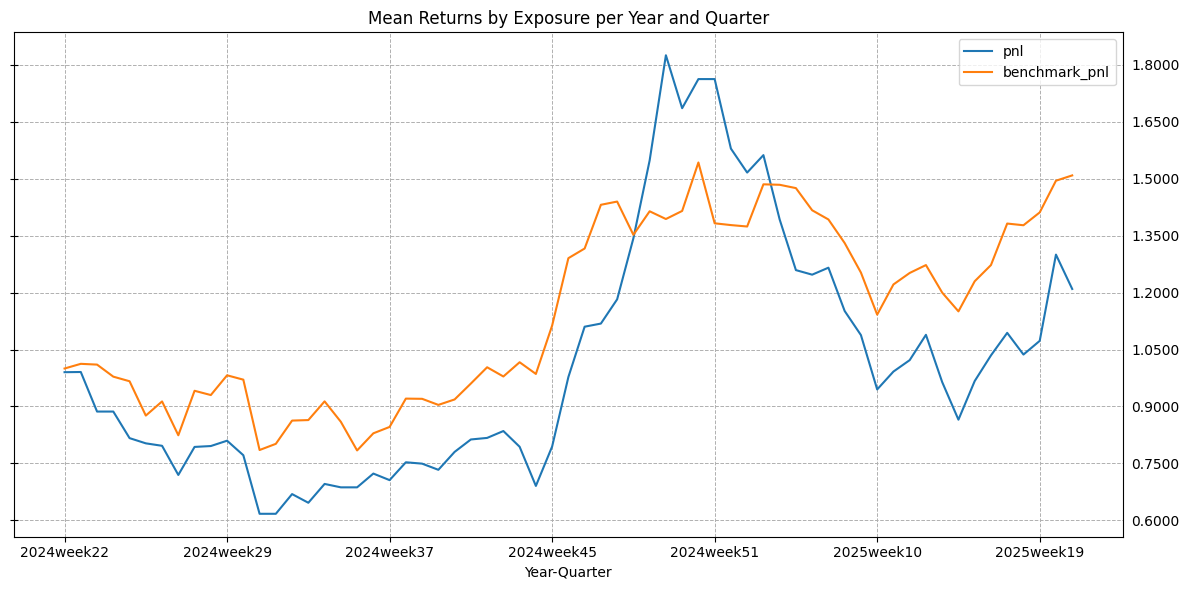

In [33]:
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + pm.timeframe.value + portfolio[pm.timeframe.value].astype(str)
ax = portfolio[["Year-Quarter","pnl","benchmark_pnl"]].set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [34]:
trades[["ticker","return"]].groupby("ticker").mean().sort_values("return",ascending=False)

,return
ticker,
XRP-USD,1.051339
CRV-USD,1.047300
FLOKI-USD,1.035212
HNT-USD,1.030712
SUI-USD,1.026568
ALGO-USD,1.024465
STX-USD,1.017210
RENDER-USD,1.015746
ARB-USD,1.014517


In [35]:
ori.cloud_connect()
ori.drop("crypto_results")
ori.store("crypto_results",pd.DataFrame([top]).drop("portfolio",axis=1))
ori.disconnect()